[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_4260\4004547049.py:55: RuntimeWarning: invalid value encountered in scalar divide
  sharpe     = port_rets.mean()/port_rets.std()*np.sqrt(252)
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_4260\4004547049.py:55: RuntimeWarning: invalid value encountered in scalar divide
  sharpe     = port_rets.mean()/port_rets.std()*np.sqrt(252)
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_4260\4004547049.py:55: RuntimeWarning: invalid value encountered in scalar divide
  sharpe     = port_rets.mean()/port_rets.std()*np.sqrt(252)
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_4260\4004547049.py:55: RuntimeWarning: invalid value encountered in scalar divide
  sharpe     = port_rets.mean()/port_rets.std()*np.sqrt(252)
C:\Users\zhiqu\AppData\Local\Temp\ipykernel_4

Best RSI low/high: 40.0 / 75.0
Sharpe: 1.84, MaxDD: 9.74%


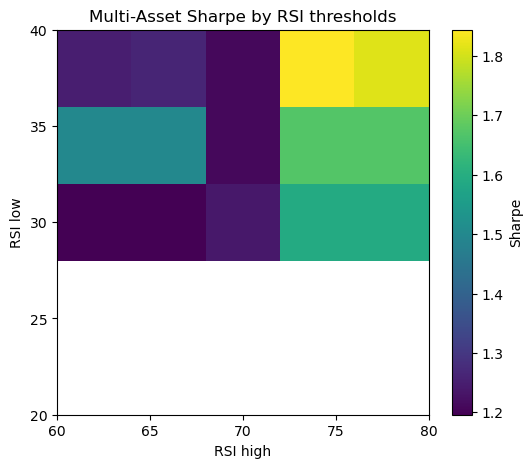

In [13]:
import itertools
import yfinance as yf
import pandas as pd
import numpy as np

# 1. configuration
tickers   = ['AAPL','SPY','XOM']
period    = '2y'
interval  = '1d'
stop_loss = 0.02  
window     = 14

# 2. Download data and compute indicators
data = {}
for t in tickers:
    df = yf.download(t, period=period, interval=interval).dropna()
    # RSI
    delta     = df['Close'].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(window).mean()
    avg_loss  = loss.rolling(window).mean()
    df['RSI'] = 100 - 100/(1 + avg_gain/avg_loss)
    # MACD (fixed 12/26/9)
    exp1        = df['Close'].ewm(span=12, adjust=False).mean()
    exp2        = df['Close'].ewm(span=26, adjust=False).mean()
    macd_line   = exp1 - exp2
    df['MACD']  = macd_line
    df['Signal']= macd_line.ewm(span=9, adjust=False).mean()
    data[t] = df

# 3. parameter grid search
results = []
for low, high in itertools.product(range(20,41,5), range(60,81,5)):
    if low >= high: continue

    # Calculate daily returns for each asset with same RSI thresholds
    rets = []
    for t, df in data.items():
        d = df.copy()
        d['Position'] = np.nan

        # Entry and exit signals
        buy  = (d['RSI'] <  low) & (d['MACD'] > d['Signal'])
        sell = (d['RSI'] > high) & (d['MACD'] < d['Signal'])
        d.loc[buy,  'Position'] = 1
        d.loc[sell, 'Position'] = 0

        # Forward-fill positions and set initial NaN to 0
        d['Position'] = d['Position'].ffill().fillna(0)
        
        # Compute daily strategy return and apply stop-loss cap
        ret = ((d['Close'].pct_change()).squeeze() * d['Position'].shift()).clip(lower=-0.02 if stop_loss else None)
        rets.append(ret.rename(t))

    # Build equally-weighted portfolio returns
    df_rets    = pd.concat(rets, axis=1)
    port_rets  = df_rets.mean(axis=1)

    # Compute cumulative return, Sharpe ratio, and max drawdown
    cumret     = (1 + port_rets).cumprod()
    sharpe     = port_rets.mean()/port_rets.std()*np.sqrt(252)
    maxdd      = (cumret.cummax()-cumret).max()

    results.append({
        'rsi_low': low,
        'rsi_high': high,
        'sharpe': sharpe,
        'max_drawdown': maxdd
    })

# 4. identify best parameters
df_res = pd.DataFrame(results)
best  = df_res.loc[df_res['sharpe'].idxmax()]
print("Best RSI low/high:", best['rsi_low'], "/", best['rsi_high'])
print(f"Sharpe: {best['sharpe']:.2f}, MaxDD: {best['max_drawdown']:.2%}")

# 5. Plot Sharpe heatmap
pivot = df_res.pivot(index='rsi_low', columns='rsi_high', values='sharpe')
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.title('Multi‐Asset Sharpe by RSI thresholds')
plt.imshow(pivot.values, origin='lower', aspect='auto',
           extent=[pivot.columns.min(), pivot.columns.max(),
                   pivot.index.min(), pivot.index.max()])
plt.colorbar(label='Sharpe')
plt.xlabel('RSI high')
plt.ylabel('RSI low')
plt.xticks(pivot.columns)
plt.yticks(pivot.index)
plt.show()
